# Distribución granulométrica de suelos

© 2023 Daniel F. Ruiz, Exneyder A. Montoya-Araque y Universidad EAFIT.

Este notebook puede ejecutarse en línea →  [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AppliedMechanics-EAFIT/soil_mechanics/blob/main/notebooks/particle_size_distrib.ipynb)

Las rutinas de clasificación se basan parcialmente en la norma [ASTM ASTM D6913/D6913M-17](https://www.astm.org/d6913-04r09e01.html)

## Módulos requeridos y configuración global de figuras

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm, lognorm
from scipy.optimize import curve_fit, minimize
from ipywidgets import widgets as wgt
from IPython import get_ipython

if 'google.colab' in str(get_ipython()):
    print('Running on CoLab. Installing the required modules...')
    from subprocess import run
    # run('pip install ipympl', shell=True);
    run('pip install openpyxl', shell=True);
    from google.colab import output, files
    output.enable_custom_widget_manager()
else:
    import tkinter as tk
    from tkinter.filedialog import askopenfilename

# %matplotlib widget
mpl.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Computer Modern Roman", "cmr", "cmr10", "DejaVu Serif"],  # or 
    "mathtext.fontset": "cm",  # Use Computer Modern fonts for math
    "axes.formatter.use_mathtext": True,  # Use mathtext for axis labels
    "axes.unicode_minus": False,   # Use standard minus sign instead of a unicode character
})

## Lectura de datos de entrada

In [2]:
if 'google.colab' in str(get_ipython()):
    file = files.upload()
    df = pd.read_excel(list(file.values())[0])
else:
    tk.Tk().withdraw() # part of the import if you are not using other tkinter functions
    file = askopenfilename()
    df = pd.read_excel(file)

## Datos de entrada tabulados

In [3]:
df

,Tamiz,Abertura_(mm),Retenido_(g)
0,"2 1/2""",63.500,NaN
1,"2""",50.800,NaN
2,"1 1/2""",38.100,NaN
3,"1""",25.400,NaN
4,"3/4""",19.100,NaN
5,"1/2""",12.700,0.0
6,4,4.760,0.0
7,8,2.380,3.4
8,10,2.000,1.8
9,30,0.590,42.5


## Funciones

In [4]:
def complete_table(df, total_sample_weight=0, washed_weight=0):
    df_full = df.fillna(0, inplace=False)
    washed_fines = total_sample_weight - washed_weight
    # df_full.iat[-1, df_full.columns.get_loc('Retenido_(g)')] = 3
    df_full.loc[len(df_full)-1, 'Retenido_(g)'] = df_full['Retenido_(g)'].iloc[-1] + washed_fines
    # df_full['Retenido_(g)'].iloc[-1] = df_full['Retenido_(g)'].copy().iloc[-1] + washed_fines
    total_weight = df_full['Retenido_(g)'].sum()
    df_full['Retenido_(%)'] = 100 * df_full['Retenido_(g)'] / total_weight
    df_full['Retenido_acum_(%)'] = 100 * np.cumsum(df_full['Retenido_(g)']) / total_weight
    df_full['No_retenido_(%)'] = 100 - df_full['Retenido_acum_(%)']
    return df_full

In [5]:
def plot_granulometric_curve(df, figsize=None):
    figsize = [6.5, 5.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize, layout='constrained')
    ax.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="-", lw=1.5, color="C0")
    # Format
    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    # ax.set_aspect("equal", anchor=None)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.tick_params(width=1.5)
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="", marker=".", color="C0")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

In [6]:
# Define the lognormal CDF function for curve fitting
def lognorm_cdf_func(x, shape, scale):
    return lognorm.cdf(x, shape, 0, scale)

def fit_lognorm(x, y, method='nlls', p0=None):
    p0 = [1, 0.5, 0.5] if p0 is None else p0
    if method == 'nlls':
        mask = ~np.isnan(y)
        x, y = x[mask], y[mask]
        bounds=([1e-9, -np.inf, 1e-9], [np.inf, np.inf, np.inf])
        params, pcov = curve_fit(lognorm.cdf, x, y, p0=p0, bounds=bounds)
    return params

def plot_granulometric_curve_fit(df, figsize=None):
    figsize = [7, 3.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    xx = np.geomspace(x[1], x[-1], 1000)
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))

    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    ax.bar(x, y_ret, width=widths, fill=False, edgecolor='k', align='edge',
        label='Probability mass function', zorder=1)
    ax.plot(x, y_ret, ls='', marker='x', c='C0', ms=7, label='Retained weight')
    ax.plot(x, y_finer, ls='--', marker='o', c='C0', mfc='w', ms=7,
        label='Weight finer than the retained')

    # params_nlls = fit_lognorm(x[1:], y_finer[1:]/100, 'nlls')
    (shape, scale), pcov = curve_fit(
        lognorm_cdf_func, x[1:], y_finer[1:]/100, p0=[1, np.median(x[1:])])
    mean, var = lognorm.stats(shape, 0, scale, moments='mv')
    ax.plot(xx, 100*lognorm.cdf(xx, shape, 0, scale), ls='-', c='C1', lw=2.5, alpha=0.8,
            label=f"$\\sigma={shape:.2f}$, $e^\\mu={scale:.2f}$\n$E[X]={mean:.2f}$, $\mathrm{{Var}}[X]={var:.2f}$")

    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing or retained [%]')
    ax.tick_params(width=1.5)
    # ax.set_xlim(1e-2, 100)
    # ax.set_ylim(-3, 103)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top"]]
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='x', ms=0, c='r')
    ax.set_xscale('log')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

def plot_pdf_cdf_granulometric_curve(df, figsize=None):
    figsize = [6.5, 6.5] if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    x = np.flip(np.array(df['Abertura_(mm)']))
    y_finer = np.flip(np.array(df['No_retenido_(%)']))
    y_ret = np.flip(np.array(df['Retenido_(%)']))
    widths = np.concatenate((np.diff(x), [2 * np.diff(x)[-1]]))
    colors = plt.get_cmap('Set3')(range(len(widths)))

    fig, axs = plt.subplots(ncols=1, nrows=2, sharex=True, sharey=True,
                            figsize=figsize, layout='compressed')

    axs[0].bar(x, y_ret, width=widths, bottom=y_finer, color=colors,
        edgecolor='k', align='edge', alpha=.8)
    axs[0].plot(x, y_finer, ls='--', lw=1.5, marker='o', c='k', mfc='w', ms=5)

    axs[1].bar(x, y_ret, width=widths, color=colors, edgecolor='k',
               align='edge', alpha=.8)
    axs[1].plot(x, y_ret, ls='', marker='o', c='k', mfc='w', ms=5)

    # Format
    axs[0].set_xscale('log')
    axs[0].set_ylim((-3, 103))
    axs[0].set(ylabel='Percent passing [%]')
    axs[1].set(xlabel='Diameter [mm]', ylabel='Percent retained [%]')
    for ax in axs:
        # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        ax.grid(True, which='both', ls="--", lw=0.5)
        ax.spines[["bottom", "left"]].set_linewidth(1.5)
        ax.tick_params(width=1.5)
    # Upper axis labels
    ax_twiny = axs[0].twiny()
    ax_twiny.plot(x, y_finer, ls='', marker='.', ms=0, c='b')
    ax_twiny.set_xscale('log')
    ax_twiny.set_xlim(axs[0].get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.spines[["top", "left"]].set_linewidth(1.5)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

In [7]:
def get_Cc_Cu(df, hztl, D60=1, D30=1, D10=1):
    figsize = [6., 3.5]# if figsize is None else figsize
    sieve = ['4', '10', '20', '40', '100', '200']
    diameters = [4.75, 2, 0.84, 0.42, 0.149, 0.074]
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=figsize)
    if D60==1 and  D30==1 and D10==1:
        label = f'Cc: -\nCu: -'
    else:
        Cu = D60/D10
        Cc = D30**2/(D60*D10)
        label = f'Cc: {Cc:.1f}\nCu: {Cu:.1f}'
    ax.semilogx(df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1],
                ls="-", lw=1.5, color="C0", label=label)
    # Format
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True, which='both', ls="--", lw=0.5)
    ax.set(xlabel='Diameter [mm]', ylabel='Percent passing [%]')
    ax.set_xlim(100, 1e-2)
    ax.set_ylim(0, 100)
    [ax.spines[i].set_linewidth(1.5) for i in ["bottom", "left", "top", "left"]]
    ax.tick_params(width=1.5)
    ax.axhline(hztl, ls='--', c='k', lw='1.5')
    ax.axvline(D60, ls='--', c='C1', lw='1.5')
    ax.axvline(D30, ls='--', c='C2', lw='1.5')
    ax.axvline(D10, ls='--', c='C3', lw='1.5')
    # Upper axis labels
    ax_twiny = ax.twiny()
    ax_twiny.semilogx(
        df['Abertura_(mm)'].iloc[:-1], df['No_retenido_(%)'].iloc[:-1], ls="", marker=".", color="C0")
    ax_twiny.set_xlim(ax.get_xlim())
    ax_twiny.set_xlabel("Sieve N$^\circ$")
    ax_twiny.minorticks_off()
    ax_twiny.set_xticks(diameters)
    ax_twiny.set_xticklabels(sieve)
    ax_twiny.spines[["bottom", "left"]].set_linewidth(1.5)
    ax_twiny.tick_params(width=1.5)
    plt.show()
    return

## Cálculos para completar la tabla

Si hay una etapa de lavado en el tamiz No. 200, incluya el peso de la muestra total antes del lavado (`total_sample_weight`) y el peso de la muestra después del lavado (`washed_weight`) como variables de entrada en la función `complete_table`. Si estos dos parámetros opcionales no se ingresan, el peso total de la muestra se calculará como la suma de los pesos retenidos.

Vea la línea comentada en la siguiente celda de código como ejemplo.

In [8]:
df_full = complete_table(df)
# df_full = complete_table(df, total_sample_weight=442.7, washed_weight=265.56)
df_full

,Tamiz,Abertura_(mm),Retenido_(g),Retenido_(%),Retenido_acum_(%),No_retenido_(%)
0,"2 1/2""",63.500,0.0,0.000000,0.000000,100.000000
1,"2""",50.800,0.0,0.000000,0.000000,100.000000
2,"1 1/2""",38.100,0.0,0.000000,0.000000,100.000000
3,"1""",25.400,0.0,0.000000,0.000000,100.000000
4,"3/4""",19.100,0.0,0.000000,0.000000,100.000000
5,"1/2""",12.700,0.0,0.000000,0.000000,100.000000
6,4,4.760,0.0,0.000000,0.000000,100.000000
7,8,2.380,3.4,1.280603,1.280603,98.719397
8,10,2.000,1.8,0.677966,1.958569,98.041431
9,30,0.590,42.5,16.007533,17.966102,82.033898


## Visualización de la curva granulométrica

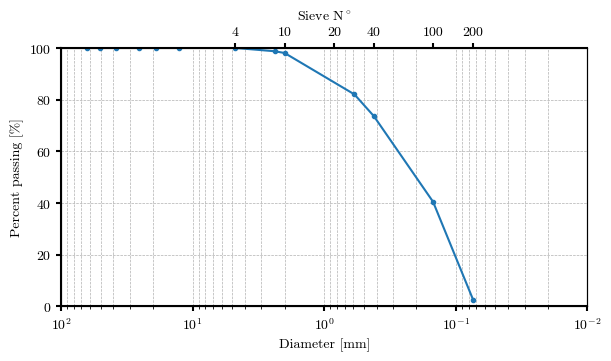

In [9]:
plot_granulometric_curve(df_full, figsize=[6., 3.5])

In [10]:
s, l = {'description_width': '70px'}, wgt.Layout(width='400px')
controls = {
    'df': wgt.fixed(df_full),
    'hztl': wgt.FloatSlider(value=50, step=1, min=0, max=100, description="Auxiliar line", style=s, layout=l),
    'D60': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D60", style=s, layout=l),
    'D30': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D30", style=s, layout=l),
    'D10': wgt.FloatLogSlider(value=1, step=0.1, min=-2, max=2, base=10, description="D10", style=s, layout=l),
}
fig = wgt.interactive_output(get_Cc_Cu, controls)
wgt.HBox((wgt.VBox(list(controls.values())[1:]), fig), layout=wgt.Layout(align_items='center'))

## Ajuste probabilístico a la curva granulométrica

### Datos de entrada discretos

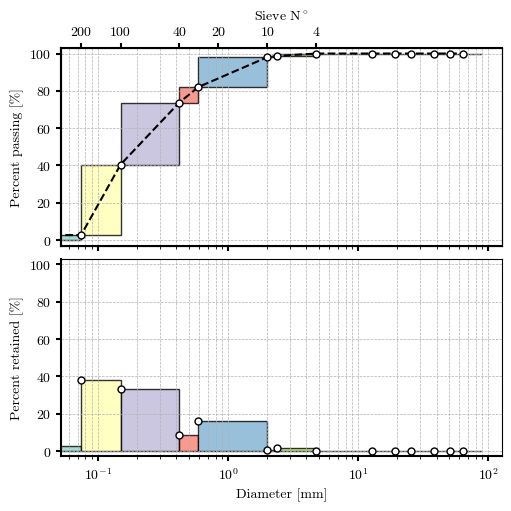

In [11]:
plot_pdf_cdf_granulometric_curve(df_full, figsize=[5, 5])

### Ajuste de una distribución lognormal a una curva granulométrica 

Si una variable aleatoria $Y=\log X$ se distribuye normalmente con media $\mu$ y desviación estándar $\sigma$, entonces la variable aleatoria $X$ es lognormalmente ditribuida con parámetros de forma (`s`=$\sigma$) y escala (`scale`=$e^\mu$)

La función de densidad de probabilidad de distribución lognormal estandarizada sólo es función del parámetro de forma `s`:

$f(x, s) = \frac{1}{s x \sqrt{2\pi}} \exp\left(-\frac{\log^2(x)}{2s^2}\right)$

con $x > 0$, $s > 0$.

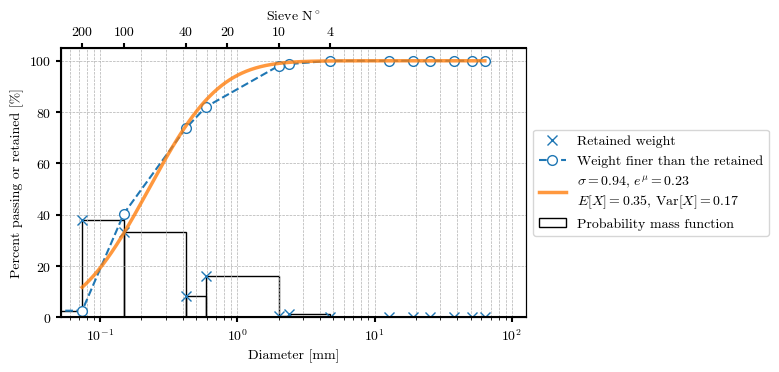

In [12]:
plot_granulometric_curve_fit(df_full, figsize=[6, 3.5])